# SHUFLLENET + SRNET 

## Import All Depedencies and Initial Settings

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, Concatenate, Dense, Dropout
from keras import Model
import numpy as np
from keras.layers import Layer
import scipy.io
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil

# Clear session to avoid memory leaks
from keras import backend as K
K.clear_session()

# Disable TensorFlow's XLA optimization to prevent compilation errors
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Set memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Disable layout optimizer and enable other safe optimizations
tf.config.optimizer.set_experimental_options({
    'layout_optimizer': False,    # Disable the layout optimizer to avoid NHWC -> NCHW conversion errors
    'constant_folding': True,     # Enable constant folding optimization
    'shape_optimization': True    # Enable shape optimization
})

tf.debugging.set_log_device_placement(False)

2024-10-29 11:50:52.532970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 11:50:52.543962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 11:50:52.547336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1730173854.500732  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730173854.520299  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

### Make sure GPU is AVAILABLE

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# ==============================
# Model Building Functions
# ==============================
class ChannelShuffleLayer(Layer):
    def __init__(self, groups, **kwargs):
        super(ChannelShuffleLayer, self).__init__(**kwargs)
        self.groups = groups

    def call(self, x):
        # Mendapatkan dimensi input
        height, width, channels = x.shape[1], x.shape[2], x.shape[3]
        group_ch = channels // self.groups

        # Reshape sesuai dengan kebutuhan pengelompokan
        x = tf.reshape(x, [-1, height, width, self.groups, group_ch])
        x = tf.transpose(x, [0, 1, 2, 4, 3])
        x = tf.reshape(x, [-1, height, width, channels])

        return x  # Pastikan hasil reshaped dikembalikan

def gconv(tensor, channels, groups):
    input_ch = tensor.shape[-1]
    group_ch = input_ch // groups
    output_ch = channels // groups
    groups_list = []
    for i in range(groups):
        group_tensor = tensor[:, :, :, i * group_ch: (i + 1) * group_ch]
        group_tensor = Conv2D(output_ch, (1, 1))(group_tensor)
        groups_list.append(group_tensor)
    output = Concatenate()(groups_list)
    return output

def shufflenet_block(x, out_channels, groups, strides):
    # Memastikan bahwa jumlah channels output bisa dibagi dengan jumlah groups
    if out_channels % groups != 0:
        raise ValueError(f"Jumlah out_channels ({out_channels}) harus bisa dibagi dengan jumlah groups ({groups}).")
    
    x = gconv(x, out_channels // 4, groups)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = ChannelShuffleLayer(groups)(x)
    
    # Mengecek dimensi setelah ChannelShuffleLayer
    if x.shape[-1] % groups != 0:
        raise ValueError(f"Jumlah channels ({x.shape[-1]}) setelah ChannelShuffleLayer harus bisa dibagi dengan jumlah groups ({groups}).")

    # Melakukan konvolusi dengan grup yang disesuaikan
    x = Conv2D(out_channels, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    return x


def shufflenet_stage(x, channels, groups, repeat):
    for i in range(repeat):
        x = shufflenet_block(x, channels, groups, strides=1)
    return x



## Build ShuffleNet and SRNet 

In [5]:
class SplitRecombineLayer(keras.layers.Layer):
    def __init__(self, global_dim, local_dim):
        super(SplitRecombineLayer, self).__init__()
        self.global_dim = global_dim
        self.local_dim = local_dim

    def build(self, input_shape):
        global_feature_dim = input_shape[-1] - self.local_dim
        self.global_context = self.add_weight(shape=(global_feature_dim, self.global_dim),
                                              initializer='random_normal',
                                              dtype=tf.float32,  
                                              trainable=True)

    def call(self, inputs):
        local_features = inputs[:, :self.local_dim]
        global_features = tf.matmul(inputs[:, self.local_dim:], self.global_context)
        combined_features = tf.concat([local_features, global_features], axis=-1)
        return combined_features

def build_body_partition(input_shape, global_dim, local_dim):
    inputs = Input(shape=input_shape)
    x = SplitRecombineLayer(global_dim=global_dim, local_dim=local_dim)(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(3, activation='linear')(x)
    model = Model(inputs, outputs)
    return model

def build_SRNet_module(features):
    flattened_features = keras.layers.GlobalAveragePooling2D()(features)
    left_arm = build_body_partition(input_shape=(6,), global_dim=4, local_dim=3)(flattened_features[:, :6])
    right_arm = build_body_partition(input_shape=(6,), global_dim=4, local_dim=3)(flattened_features[:, 6:12])
    left_leg = build_body_partition(input_shape=(6,), global_dim=4, local_dim=3)(flattened_features[:, 12:18])
    right_leg = build_body_partition(input_shape=(6,), global_dim=4, local_dim=3)(flattened_features[:, 18:24])
    torso = build_body_partition(input_shape=(6,), global_dim=4, local_dim=3)(flattened_features[:, 24:30])
    combined_output = keras.layers.concatenate([left_arm, right_arm, left_leg, right_leg, torso], axis=-1)
    x = Dense(128, activation='relu')(combined_output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(32, activation='linear')(x)  # Output koordinat keypoints (16 koordinat)
    return outputs
    
def build_shufflenet_srnet(input_shape=(224, 224, 3), groups=8):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Dropout(0.5)(x)
    x = shufflenet_stage(x, channels=128, groups=groups, repeat=2)
    x = Dropout(0.5)(x)
    x = shufflenet_stage(x, channels=256, groups=groups, repeat=4)
    x = Dropout(0.5)(x)
    x = shufflenet_stage(x, channels=512, groups=groups, repeat=2)
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    pose_estimation_output = build_SRNet_module(x)
    model = Model(inputs, pose_estimation_output)
    return model


## Splits Dataset Into Training and Validation



In [7]:
def split_dataset_into_train_val(main_folder, train_folder, val_folder, train_ratio=0.8):
    # Buat folder training dan validation jika belum ada
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    
    # Dapatkan semua file gambar dalam folder utama
    image_files = [f for f in os.listdir(main_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Split file menjadi bagian training dan validation
    train_files, val_files = train_test_split(image_files, train_size=train_ratio, random_state=42)

    # Pindahkan gambar ke folder training dengan progress bar
    print("Memindahkan file ke folder training...")
    for file in tqdm(train_files, desc="Training", unit="file"):
        src_path = os.path.join(main_folder, file)
        dst_path = os.path.join(train_folder, file)
        shutil.copy(src_path, dst_path)
    
    # Pindahkan gambar ke folder validation dengan progress bar
    print("Memindahkan file ke folder validation...")
    for file in tqdm(val_files, desc="Validation", unit="file"):
        src_path = os.path.join(main_folder, file)
        dst_path = os.path.join(val_folder, file)
        shutil.copy(src_path, dst_path)

    print(f"Dataset split complete. {len(train_files)} images in training set, {len(val_files)} images in validation set.")


## Place the Dataset Directory 
* Uncomment the cell below if you have not split the dataset

In [8]:
# main_folder = '/mnt/d/iipp_projects/Program/MPII_Dataset/mpii_human_pose_v1_image/images' 
# train_folder = '/mnt/d/iipp_projects/Program/MPII_Dataset/training_images'
# val_folder = '/mnt/d/iipp_projects/Program/MPII_Dataset/validation_images'

# # Start the split process
# split_dataset_into_train_val(main_folder, train_folder, val_folder, train_ratio=0.9)

## MPII Dataset Preprocessing

In [9]:


def load_mpii_data(annotations, image_folder, batch_size=200):
    mpii_idx_to_jnt = {
        0: 'rankl', 1: 'rknee', 2: 'rhip', 3: 'lhip', 4: 'lknee', 5: 'lankl',
        6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 9: 'head', 10: 'rwri', 11: 'relb',
        12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'
    }
    processed_annotations = []
    for start_idx in range(0, len(annotations), batch_size):
        end_idx = min(start_idx + batch_size, len(annotations))
        for img_idx in tqdm(range(start_idx, end_idx), desc="Processing images"):
            try:
                img_data = annotations[img_idx]
                img_name = img_data.image[0, 0].name[0]
                img_path = os.path.join(image_folder, img_name)
                if not os.path.exists(img_path):
                    print(f"Image not found: {img_path}")
                    continue
                keypoints_list = []
                has_annotation = False
                if hasattr(img_data, 'annorect'):
                    for annorect in img_data.annorect[0]:
                        if hasattr(annorect, 'annopoints') and len(annorect.annopoints) > 0:
                            points = annorect.annopoints[0, 0].point[0]
                            keypoints = [
                                {
                                    'x': point.x[0][0], 
                                    'y': point.y[0][0], 
                                    'joint': mpii_idx_to_jnt[point.id[0][0]],
                                    'vis': point.is_visible[0][0] if len(point.is_visible) else 1
                                }
                                for point in points
                            ]
                            keypoints_list.append(keypoints)
                            has_annotation = True
                if has_annotation:
                    processed_annotations.append({'image_path': img_path, 'keypoints': keypoints_list})
            except Exception as e:
                print(f"Error processing image {img_idx}: {str(e)}")
                continue
    return processed_annotations



In [10]:
# ==============================
# New tf.data Generator Integration
# ==============================
mpii_idx_to_jnt = {
    0: 'rankl', 1: 'rknee', 2: 'rhip', 3: 'lhip', 4: 'lknee', 5: 'lankl',
    6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 9: 'head', 10: 'rwri', 11: 'relb',
    12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'
}

def create_tf_data_pipeline_from_processed(processed_data, batch_size=8, img_size=224, num_keypoints=16):
    def generator():
        for data in processed_data:
            img = keras.preprocessing.image.load_img(data['image_path'], target_size=(img_size, img_size))
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            keypoints = np.zeros((num_keypoints * 2,))
            for person in data['keypoints']:
                for joint in person:
                    if joint['vis']:  # If joint is visible
                        idx = list(mpii_idx_to_jnt.values()).index(joint['joint'])
                        keypoints[idx * 2] = joint['x'] / img_size
                        keypoints[idx * 2 + 1] = joint['y'] / img_size
            yield img_array, keypoints
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_keypoints * 2,), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [12]:
# ==============================
# Separate Annotations Function
# ==============================

def separate_annotations(mat_file, train_folder, val_folder):
    matlab_data = scipy.io.loadmat(mat_file, struct_as_record=False)['RELEASE'][0, 0]
    annotations = matlab_data.annolist[0]
    train_files = set(os.listdir(train_folder))
    val_files = set(os.listdir(val_folder))
    train_annotations = []
    val_annotations = []
    for img_data in tqdm(annotations, desc="Processing annotations"):
        img_name = img_data.image[0, 0].name[0]
        if img_name in train_files:
            train_annotations.append(img_data)
        elif img_name in val_files:
            val_annotations.append(img_data)
    return train_annotations, val_annotations

In [1]:
# ==============================
# Compile and Train the Model
# ==============================

mat_file = '/mnt/d/iipp_projects/Program/MPII_Dataset/mpii_human_pose_ann/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'
train_folder = '/mnt/d/iipp_projects/Program/MPII_Dataset/training_images'
val_folder = '/mnt/d/iipp_projects/Program/MPII_Dataset/validation_images'

# Separate annotations and load data
train_annotations, val_annotations = separate_annotations(mat_file, train_folder, val_folder)
train_data = load_mpii_data(train_annotations, train_folder)
val_data = load_mpii_data(val_annotations, val_folder)

NameError: name 'separate_annotations' is not defined

In [14]:
# Create tf.data pipelines
train_dataset = create_tf_data_pipeline_from_processed(train_data, batch_size=64).repeat()
val_dataset = create_tf_data_pipeline_from_processed(val_data, batch_size=4).repeat()

I0000 00:00:1730173883.182092  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730173883.182226  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730173883.182263  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730173883.310721  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730173883.310806  112429 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Create Cosine Annealing Learning Rate

In [11]:
# ==============================
# Cosine Annealing Learning Rate Schedule
# ==============================

def cosine_annealing_schedule(epoch, lr):
    max_lr = 3e-3
    min_lr = 1e-12
    t_max = 10
    return min_lr + (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / t_max)) / 2

## Create PCK Function

In [15]:
def pck(y_true, y_pred, threshold=0.05, img_size=224):
    """
    Computes the Percentage of Correct Keypoints (PCK) metric.

    Parameters:
    y_true -- true keypoint coordinates, shape (batch_size, num_keypoints * 2), in pixel scale
    y_pred -- predicted keypoint coordinates, shape (batch_size, num_keypoints * 2), normalized to [0, 1]
    threshold -- threshold for determining if a keypoint is correctly predicted (as a fraction of image size)
    img_size -- the size of the image (e.g., 224 if the image is 224x224 pixels)

    Returns:
    pck_value -- percentage of correct keypoints
    """
    # Mengubah prediksi dari skala [0, 1] menjadi skala pixel (misal 224x224)
    y_pred_scaled = y_pred * img_size

    # Reshape y_true and y_pred to shape (batch_size, num_keypoints, 2)
    y_true_reshaped = tf.reshape(y_true, (-1, tf.shape(y_true)[1] // 2, 2))
    y_pred_reshaped = tf.reshape(y_pred_scaled, (-1, tf.shape(y_pred)[1] // 2, 2))
    
    # Menghitung jarak Euclidean untuk setiap keypoint
    dists = tf.sqrt(tf.reduce_sum(tf.square(y_pred_reshaped - y_true_reshaped), axis=-1))
    
    # Menghitung threshold dalam satuan pixel
    threshold_pixel = threshold * img_size
    
    # Menghitung PCK untuk setiap keypoint
    correct_keypoints = tf.reduce_sum(tf.cast(dists < threshold_pixel, tf.float32))
    total_keypoints = tf.cast(tf.size(dists), tf.float32)
    
    # Menghitung persentase correct keypoints
    pck_value = correct_keypoints / total_keypoints
    return pck_value


## Initialize The Model

In [16]:
# Initialize and compile model
model = build_shufflenet_srnet(input_shape=(224, 224, 3), groups=4)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000001), 
              loss='mean_squared_error', 
              metrics=['mae', rmse, pck])

In [17]:
# Cosine Annealing Learning Rate Scheduler
lr_scheduler = keras.callbacks.LearningRateScheduler(cosine_annealing_schedule)

In [18]:
from tensorflow.data import AUTOTUNE

train_cardinality = tf.data.experimental.cardinality(train_dataset)
val_cardinality = tf.data.experimental.cardinality(val_dataset)

# Periksa apakah cardinality diketahui (bukan infinity atau tidak diketahui)
if tf.data.experimental.INFINITE_CARDINALITY == train_cardinality:
    train_cardinality = len(train_data) // 64
elif tf.data.experimental.UNKNOWN_CARDINALITY == train_cardinality:
    train_cardinality = len(train_data) // 64
else:
    train_cardinality = train_cardinality.numpy()

if tf.data.experimental.INFINITE_CARDINALITY == val_cardinality:
    val_cardinality = len(val_data) // 4
elif tf.data.experimental.UNKNOWN_CARDINALITY == val_cardinality:
    val_cardinality = len(val_data) // 4
else:
    val_cardinality = val_cardinality.numpy()


## Saving the record in CSV

In [20]:
csv_logger = keras.callbacks.CSVLogger('metrics_part_1.csv')

In [21]:
# Gunakan cardinality yang dihitung saat memanggil model.fit()
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=train_cardinality,
    validation_steps=val_cardinality,
    callbacks=[lr_scheduler,
                            csv_logger]
)

Epoch 1/20


I0000 00:00:1730173897.338947  113086 service.cc:146] XLA service 0x7fa920003780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730173897.338977  113086 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1730173922.928578  113086 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/266 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - loss: 2.5362 - mae: 1.2184 - pck: 0.0411 - rmse: 1.5612 - val_loss: 6.4059 - val_mae: 2.1050 - val_pck: 0.0000e+00 - val_rmse: 2.4990 - learning_rate: 0.0030
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - loss: 2.0776 - mae: 1.1125 - pck: 0.0000e+00 - rmse: 1.4262 - val_loss: 8.6015 - val_mae: 2.3320 - val_pck: 0.0000e+00 - val_rmse: 2.8211 - learning_rate: 0.0029
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - loss: 2.0675 - mae: 1.1122 - pck: 0.0000e+00 - rmse: 1.4222 - val_loss: 9.8255 - val_mae: 2.5611 - val_pck: 0.0000e+00 - val_rmse: 3.0552 - learning_rate: 0.0027
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - loss: 2.0787 - mae: 1.1164 - pck: 0.0000e+00 - rmse: 1.4260 - val_loss: 9.0542 - val_mae: 2.3564 - val_pck: 0.0000e+00 - val_rmse: 2.8944 - learning_rate: 0.0024
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - loss: 2.0671 - mae: 1.1128 - pck: 0.0000e+00 - rmse: 1.4225 - val_loss: 14.0311 - val_mae: 2

In [23]:
history.history.keys()

dict_keys(['loss', 'mae', 'pck', 'rmse', 'val_loss', 'val_mae', 'val_pck', 'val_rmse', 'learning_rate'])

In [24]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 56, 56, 4) │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 56, 56, 4) │          0 │ dropout[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 56, 56, 4) │          0 │ dropout[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 56, 56, 4) │          0 │ dropout[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56, 8) │         40 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56, 8) │         40 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56, 8) │         40 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56, 8) │         40 │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 32)               │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_shuffle_la… │ (None, 56, 56,    │          0 │ re_lu_1[0][0]   

 Total params: 7,633,283 (29.12 MB)

 Trainable params: 2,542,411 (9.70 MB)

 Non-trainable params: 6,048 (23.62 KB)

 Optimizer params: 5,084,824 (19.40 MB)

In [30]:
import matplotlib.pyplot as plt

def plot_training_performance(history, phase_num=1):
    """
    Function to plot training performance from the history object.

    Parameters:
    history -- Keras History object from model training
    phase_num -- The phase number or stage for training (useful if training is done in phases)
    """
    # Plot Mean Absolute Error (MAE) if it exists in history
    if 'mae' in history.history and 'val_mae' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title(f'Mean Absolute Error (MAE) per Epoch (Phase {phase_num})')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Error')
        plt.legend(loc='upper right')
        plt.show()

    # Plot RMSE if available in history
    if 'rmse' in history.history and 'val_rmse' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['rmse'], label='Train RMSE')
        plt.plot(history.history['val_rmse'], label='Validation RMSE')
        plt.title(f'Root Mean Squared Error (RMSE) per Epoch (Phase {phase_num})')
        plt.xlabel('Epoch')
        plt.ylabel('Root Mean Squared Error')
        plt.legend(loc='upper right')
        plt.show()

    # Plot PCK if available in history
    if 'pck' in history.history and 'val_pck' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['pck'], label='Train PCK')
        plt.plot(history.history['val_pck'], label='Validation PCK')
        plt.title(f'Percentage of Correct Keypoints (PCK) per Epoch (Phase {phase_num})')
        plt.xlabel('Epoch')
        plt.ylabel('PCK')
        plt.legend(loc='upper right')
        plt.show()

    # Plot Loss
    if 'loss' in history.history and 'val_loss' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Loss per Epoch (Phase {phase_num})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()


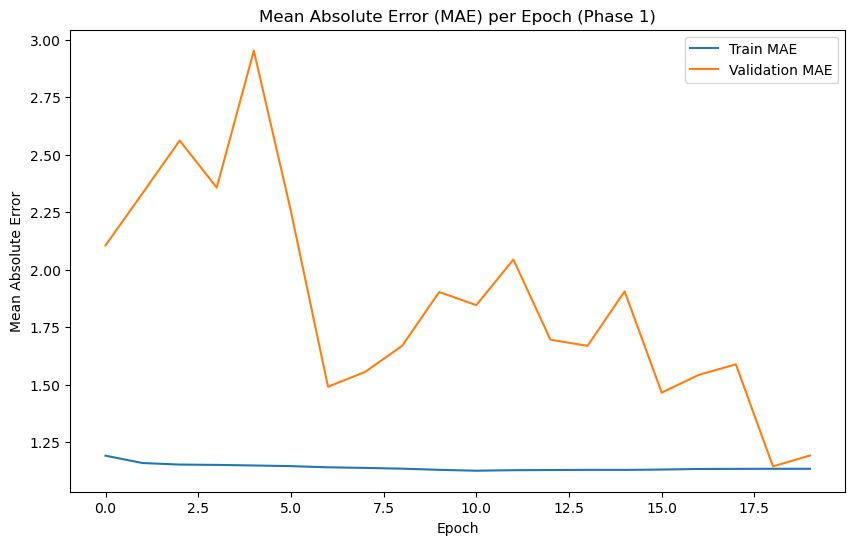

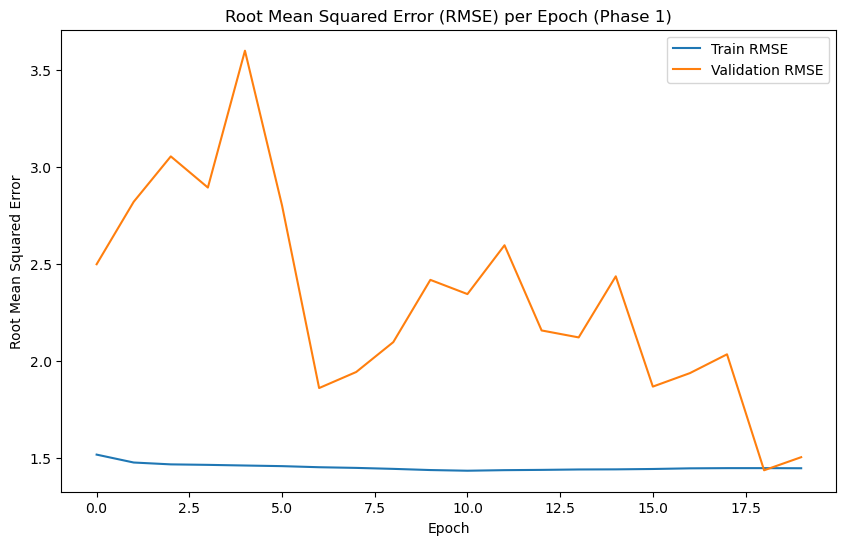

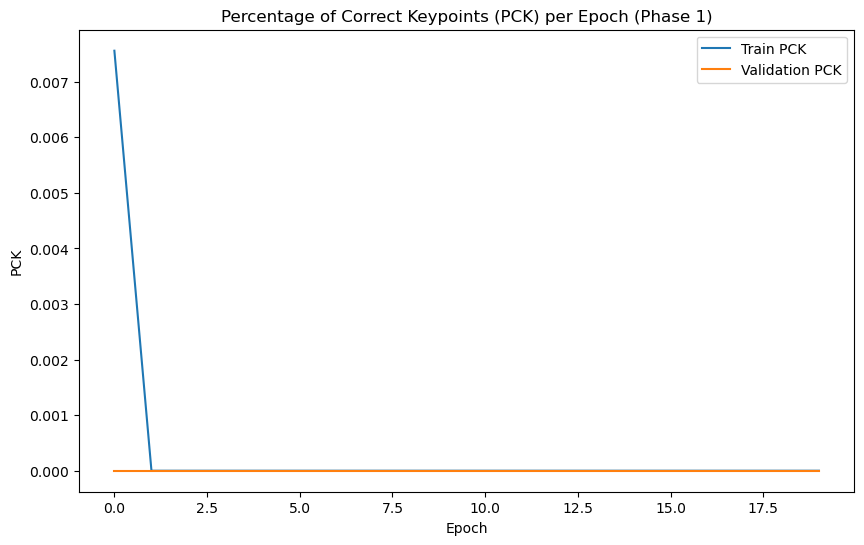

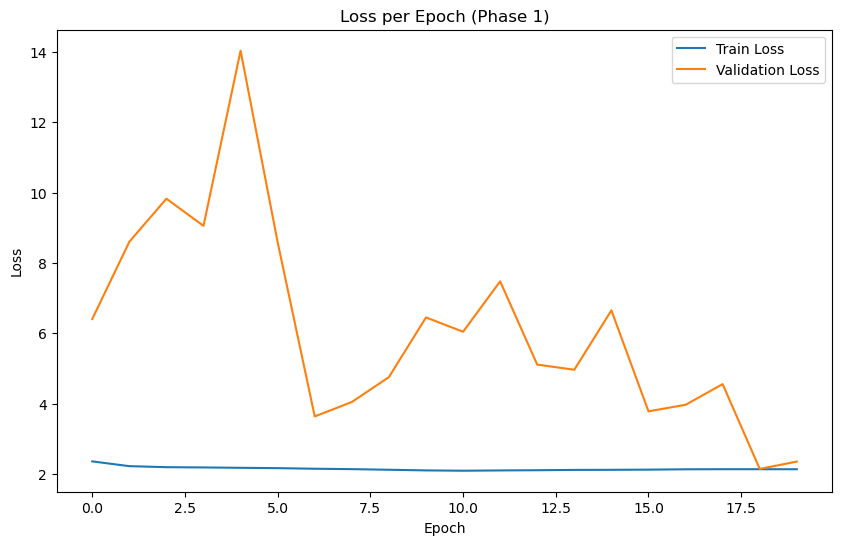

In [31]:
plot_training_performance(history, phase_num=1)

In [27]:
# Save the model after training
model.save('/mnt/d/iipp_projects/Program/Model/ShuffleNet_SRNet/shufflenet_srnet_model_16_4(part_1).keras')

In [28]:
# Save the model after training
model.save('/mnt/d/iipp_projects/Program/Model/ShuffleNet_SRNet/shufflenet_srnet_model_16_4(part_1).h5')

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# Definisikan pasangan keypoints untuk skeleton
SKELETON_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),     # Tangan kiri
    (1, 5), (5, 6), (6, 7),             # Tangan kanan
    (1, 8), (8, 9), (9, 10),            # Kaki kiri
    (1, 11), (11, 12), (12, 13),        # Kaki kanan
    (2, 5), (8, 11)                     # Garis tubuh tengah
]

def visualize_keypoints_with_skeleton(model, image_path, img_size=224, num_keypoints=18, confidence_threshold=0.5):
    # Load gambar asli dan simpan ukurannya
    original_img = load_img(image_path)
    original_width, original_height = original_img.size
    
    # Load dan rescale gambar sesuai dengan ukuran model input
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Dapatkan prediksi dari model (koordinat keypoints)
    keypoints = model.predict(img_array)[0]  # Ambil hasil dari batch pertama

    # Jika model juga mengeluarkan confidence scores, pisahkan (x, y, score) untuk setiap keypoint
    if keypoints.shape[-1] == 3:
        x_coords = keypoints[:, 0]
        y_coords = keypoints[:, 1]
        confidences = keypoints[:, 2]
    else:
        # Asumsi keypoints hanya berisi koordinat (x, y) tanpa confidence
        x_coords = keypoints[::2]
        y_coords = keypoints[1::2]
        confidences = np.ones(len(x_coords))  # Anggap semua keypoints valid jika tidak ada confidence score

    # Konversi koordinat ke skala [0, 1] jika diperlukan
    if np.max(x_coords) > 1.0 or np.max(y_coords) > 1.0:
        x_coords = x_coords / img_size
        y_coords = y_coords / img_size

    # Sesuaikan koordinat agar sesuai dengan gambar asli
    x_coords = x_coords * original_width
    y_coords = y_coords * original_height

    # Visualisasi gambar asli
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)

    # Visualisasikan keypoints yang memiliki confidence di atas threshold
    for x, y, conf in zip(x_coords, y_coords, confidences):
        if conf > confidence_threshold:
            plt.scatter(x, y, c='red', s=40, marker='o')

    # Visualisasikan skeleton berdasarkan pasangan keypoints
    for connection in SKELETON_CONNECTIONS:
        start_idx, end_idx = connection
        if (confidences[start_idx] > confidence_threshold and confidences[end_idx] > confidence_threshold):
            x_start, y_start = x_coords[start_idx], y_coords[start_idx]
            x_end, y_end = x_coords[end_idx], y_coords[end_idx]
            plt.plot([x_start, x_end], [y_start, y_end], 'yellow', linewidth=2)

    plt.title('Visualisasi Keypoints dan Skeleton')
    plt.axis('off')
    plt.show()

# Contoh penggunaan
image_path = '/mnt/d/iipp_projects/Program/Testing_image/Testing_image.jpg' 
visualize_keypoints_with_skeleton(model, image_path)


PermissionError: [Errno 13] Permission denied: '/mnt/d/iipp_projects/Program/Testing_image/Testing_image.jpg'